[View in Colaboratory](https://colab.research.google.com/github/marcocaserta/ecco/blob/master/eccoApp.ipynb)

In [0]:
from google.colab import widgets
from google.colab import output   
import matplotlib.pyplot as plt
from __future__ import print_function
import itertools
from google.colab import files
import numpy as np
import pandas as pd
import io, os
import re, string
import textwrap
import html
from IPython.display import display, HTML


In [361]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   DIM  =  '\033[90m'
   UNDERLINE = '\033[4m'
   ITALIC =  '\033[3m'
   BULLET = '\u2022'
   END = '\033[0m '

#print(color.ITALIC + 'Hello World !' + color.END)
#print(color.DIM +  'First sentence')
#print(html.unescape("&#x0027;"))

#display(HTML("HERE is &#x0027;"))


In [293]:
def createDataFrame(df, dfQuery):
  count             = []
  percent           = []
  dfQuery.tokenized = tknz(dfQuery.tokenized)
  lenQuery        = len(dfQuery.tokenized)
  for i in range(len(df)):
      vect     = tknz(df.iloc[i].tokenized)
      nSent    = len(vect)
      nShared  = sum([w in vect for w in dfQuery.tokenized])
      count.append(nShared)
      percent.append(nShared/lenQuery)
  df["nShared"] = count
  df["percent"] = percent

  return df, dfQuery, lenQuery

# preprocess tokenized senteces
def tknz(sentence):
  sentence = sentence.strip("[,']")
  regex = re.compile(' [%s]' % re.escape(string.punctuation))
  sentence = regex.sub('', sentence)
  vect = sentence.strip(",").split("'")
  final = [w.strip(",") for w in vect]
  return final

def setTitle(dfQuery):
    titleText = "<center><h4>Query : <b>" + dfQuery.sentence.strip("[] '") + "</b> </h4>"
    titleText += "<i>" + str(dfQuery.tokenized) + "</i></center>"
    return titleText

def setTitle2(dfQuery):
  
    titleText = "Query : " + color.BOLD + dfQuery.sentence.strip("[] '") + color.END + "\n"
    titleText += color.ITALIC + str(dfQuery.tokenized) + color.END
    return titleText
  
def formatting(sent,i):
    block= "<li>" + sent.previous.strip("[] '") + " " 
    block+= "<b>" + sent.sentence.strip("[] '") + "</b>" + " "
    block+= sent.next.strip("[] '") + "</li>"
    block+= "<font color='#999999' size='1'>(" + str(i+1) + "-Sentence id = " + str(sent.id)
    block+= "; score = " + str(np.round(sent.score,3))
    block+= "; overlap = " + str(np.round(sent.percent,2))
    block+= "; keywords = " + sent.tokenized + ") </font>"
    return block

def formatting2(sent,i):
  block = color.BULLET + " " + html.unescape(sent.previous.strip("[] '")) + " " 
  block+= color.BOLD + " " + html.unescape(sent.sentence.strip("[] '")) + color.END + " "
  block+= html.unescape(sent.next.strip("[] '")) + "\n"
  block+= color.DIM + "\n(" + str(i+1) + "-Sentence id = " + str(sent.id)
  block+= "; score = " + str(np.round(sent.score,3))
  block+= "; overlap = " + str(np.round(sent.percent,2))
  block+= "; keywords = " + sent.tokenized + ")" + color.END
  return block

def createBlocks(ddf):
  if len(ddf) == 0:
    return []
  ww = []
  for i in range(len(ddf)):
      block = formatting(ddf.iloc[i],i)
      ww.append(block)  
  return ww

In [347]:

def createTable(nQuery):
    bins = [i for i in range(nQuery+1)]
    ncounting = []
    for pp in bins:
        ncounting.append(df.loc[df.nShared==pp, 'nShared' ].count())
    table = pd.DataFrame({
        "nr. words" : bins,
        "percent" : [np.round(i/nQuery,3) for i in bins],
        "freq"    : ncounting
    })
    table = table.reindex(['nr. words', 'percent','freq'], axis=1)
    return table
  
def createTableYear(df,periods):
    ncounting = []
    bins = periods
    for yy in bins:
      ncounting.append(df.loc[df.year==yy, 'year'].count())
    tableYear = pd.DataFrame({"year": bins, "freq":ncounting})
    tableYear = tableYear.reindex(['year','freq'], axis=1)
    return tableYear
  
def createTableWords(df):
    nWords = 10
    vecs = []
    for i in range(len(df)):
      vect = tknz(df.iloc[i].tokenized)
      vecs.append(vect)
    dd = {key:0 for i in range(nTop) for key in vecs[i] }
    for i in range(nTop):
        for w in vecs[i]:
            dd[w] += 1

    words = sorted(dd, key=dd.get, reverse=True)[:nWords]
    vals  = [dd[w] for w in words]
    percent = [np.round(v/nTop, 3) for v in vals]
    dfWords= pd.DataFrame({"word":words,"freq":vals, "percent": percent})
    dfWords = dfWords.reindex(['word', 'percent','freq'], axis=1)
    return dfWords
  
def createChart1(df, lenQuery):
    plt.figure(figsize=(4,4)) 
    bins = [i for i in range(lenQuery+1)]
    ax = plt.gca()
    ax.hist(df.nShared, bins=bins, edgecolor="white", linewidth=1.5, alpha=0.9, align="left")
    ax.set_xticks(bins)
    ax.set_title("Distribution of Sentences over Overlap Values")
    plt.show()

def createChart2(df, lenQuery):
    plt.figure(figsize=(4,4)) 
    ax = plt.gca()
    bins = np.arange(np.min(df.year), np.max(df.year)+2)
    ax.hist(df.year, bins=bins, align="left", edgecolor="white", linewidth=1.5, alpha=0.9)
    ax.set_xticks(bins[:-1])
    ax.set_title("Distribution of Top Sentences over Time Period")

    
def createChart3(dfWords, lenQuery):
    plt.figure(figsize=(4,4)) 
    ax = plt.gca()
    ax.bar(dfWords.word,dfWords.freq, edgecolor="white", linewidth=1.5, alpha=0.9)
    for tick in ax.get_xticklabels():
      tick.set_rotation(60)
    ax.set_title("Distribution of Words among Top Sentences")
    plt.show()


In [345]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
dfAux = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

# separate query and results
dfQuery = dfAux.iloc[-1]
dfAux = dfAux.iloc[:-1]
df, dfQuery, lenQuery = createDataFrame(dfAux, dfQuery)

Saving sol.csv to sol (8).csv
User uploaded file "sol.csv" with length 225054 bytes


o vs l 5   4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,nr. words,percent,freq
0,0,0.00,6
1,1,0.25,493
2,2,0.50,1
3,3,0.75,0
4,4,1.00,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,year,freq
0,1796,500
1,1797,0
2,1798,0
3,1799,0
4,1800,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,word,percent,freq
0,still,0.750,375
1,monarchy,0.220,110
2,government,0.060,30
3,remains,0.036,18
4,may,0.034,17
5,limited,0.032,16
6,however,0.032,16
7,form,0.026,13
8,institution,0.024,12
9,french,0.022,11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

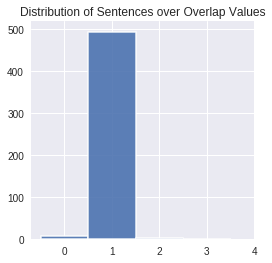

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

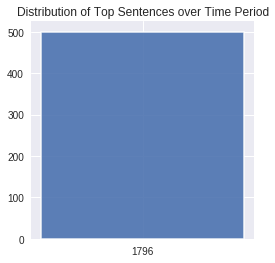

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

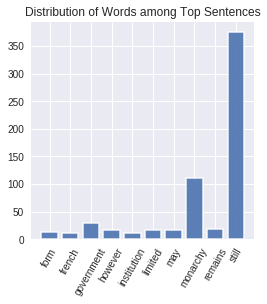

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [360]:
#@title Parameters :
Overlap = 5 #@param {type:"slider", min:0, max:10, step:1}

if Overlap > lenQuery:
  print("o vs l", Overlap, " ", lenQuery)
  Overlap = lenQuery
  
nTop = len(df)
periods = np.arange(1796,1801)

def create_tab(location): 
  tb = widgets.TabBar(['Analysis', 'Charts'], location=location)
  with tb.output_to('Analysis'):
    ddf  = df[ df.nShared== Overlap]
    listBlock = createBlocks(ddf)
    txt=("<h4><p><b>[" + str(np.round(Overlap/lenQuery,2)) + " ] Found " + str(len(ddf)) + "/" + str(len(df)) + " sentences : </b></p></h4>"   )
    display(HTML(txt))
    for w in listBlock:
      #print(textwrap.fill(w,width=Text_width,  initial_indent='', subsequent_indent='    '))
      display(HTML(w))
  with tb.output_to(1,select=False):
    table     = createTable(lenQuery)
    tableYear = createTableYear(df,periods)
    tableWord = createTableWords(df)

    grid = widgets.Grid(2,3,header_row=False, header_column=False, style=output)
    with grid.output_to(0,0):
           display(HTML("<center><u>Frequence of Overlaps</u></center>" ))
           display(table)
    with grid.output_to(0,1):
           display(HTML("<u>Frequence Per Year</u>" ))
           display(tableYear)
    with grid.output_to(0,2):
           display(HTML("<center><u>Words Distribution</u></center>" ))
           display(tableWord)
    with grid.output_to(1,0):
      createChart1(df, lenQuery)
    with grid.output_to(1,1):
      createChart2(df, lenQuery)
    with grid.output_to(1,2):
      createChart3(tableWord, lenQuery)

         

title=setTitle(dfQuery)
display(HTML(title))
#parser.feed(title)
create_tab("top")


  

In [356]:
CSS = """
.output {
        border: 10px solid green;
}
"""

